# Training

In [2]:
from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
# set_random_seed(2)

In [3]:
from keras.models import Model
from keras.layers import Dense, GaussianNoise, Input
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model
import numpy as np

In [4]:
# Creation of custom AWGN layer
from keras import backend as K
from keras.engine.topology import Layer

class AWGN(Layer):

    def __init__(self, stddev, **kwargs):
        super(AWGN, self).__init__(**kwargs)
        self.supports_masking = True
        self.stddev = stddev

    def call(self, inputs, training=None):
        def noised():
            return inputs + K.random_normal(shape=K.shape(inputs),
                                            mean=0.,
                                            stddev=self.stddev)
        return K.in_train_phase(noised, noised, training=training)

    def get_config(self):
        config = {'stddev': self.stddev}
        base_config = super(AWGN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [18]:
# Dataset genetation
signal =  [[0,0,0,0,0,0,0],
           [1,0,0,0,0,0,0],
           [0,1,0,0,0,0,0],
           [0,0,1,0,0,0,0],
           [0,0,0,1,0,0,0],
           [0,0,0,0,1,0,0],
           [0,0,0,0,0,1,0],
           [0,0,0,0,0,0,1]]

signal2 =  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0],
           [1,0,0,0,0,0,0,1,0,0,0,0,0,0],
           [0,1,0,0,0,0,0,0,1,0,0,0,0,0],
           [0,0,1,0,0,0,0,0,0,1,0,0,0,0],
           [0,0,0,1,0,0,0,0,0,0,1,0,0,0],
           [0,0,0,0,1,0,0,0,0,0,0,1,0,0],
           [0,0,0,0,0,1,0,0,0,0,0,0,1,0],
           [0,0,0,0,0,0,1,0,0,0,0,0,0,1]]

target =  [[0,0,0,0,0,0,0,1],
           [1,0,0,0,0,0,0,0],
           [0,1,0,0,0,0,0,0],
           [0,0,1,0,0,0,0,0],
           [0,0,0,1,0,0,0,0],
           [0,0,0,0,1,0,0,0],
           [0,0,0,0,0,1,0,0],
           [0,0,0,0,0,0,1,0]]

indexes = np.random.choice(8, 100000)

TrainX = np.array([signal2[i] for i in indexes[0:80000]])
Trainy = np.array([signal[i] for i in indexes[0:80000]]) # changed target to signal for buildmodel3

TestX = np.array([signal2[i] for i in indexes[80000:100000]])
Testy = np.array([signal[i] for i in indexes[80000:100000]]) # changed target to signal for buildmodel3

k*Ec = n*Eb 

k = 7, n = 6
Eb = 1     {due to batch-normalization}

hence, Ec = 6/7

SNR = 10∗log(6/7(No))
where No = 2σ^2     {σ is standard deviation}

∴  σ^2 = 6/( 14*10^(SNR/10) )

∴  σ = √6/( 14∗10^(SNR/10) )

In [19]:
# SNR = np.arange(0.0, 8.5, 0.5)
SNR = [0.0, 2.5, 5.0, 8.0]
# SNR = [5.0]
stdRange = [( 6.0/(14*(10**(snr/10))) )**.5 for snr in SNR]

In [20]:
from keras.layers import LeakyReLU
from keras.optimizers import Adam 

**Model Architecture**

In [21]:
def BuildModel(std):
#   set_random_seed(2)
  # placeholder for input signal
  input_sig = Input(shape=(14,))

  # source-coding
  encode = Dense(8, activation=LeakyReLU(alpha=0.1), name='dense_1')(input_sig)
  # channel-coding
  encode = Dense(6, activation=LeakyReLU(alpha=0.1), name='dense_2')(encode)
  # batch-normalization
  encode = BatchNormalization(epsilon=1e-06, center=False, scale=False, name='batch_normalization_1')(encode)

  # noise layer
  channel = AWGN( stddev=std )(encode)

  # channel-decoding
  decode = Dense(6, activation=LeakyReLU(alpha=0.1), name='dense_3')(channel)
  # source-decoding
#   decode = Dense(3, activation=LeakyReLU(alpha=0.1), name='dense_4')(decode)
  # output layer
  decode = Dense(7, activation="sigmoid", name='dense_5')(decode)

  model = Model(input_sig, decode)
  return model

In [22]:
# import tensorflow as tf

In [23]:
# init = tf.global_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init)
#     v = sess.run(a)
#     r = sess.run(b)
#     print v
#     print "\n"
#     print r
#     sess.close()

In [24]:
jsccModels = [BuildModel(std) for std in stdRange]

**Train model**

In [25]:
for i in range(len(jsccModels)):
  print "Now compiling model with " + str(SNR[i]) + " SNR.\n"
  jsccModels[i].compile(optimizer=Adam(lr=0.0005),
                loss='mse',
                metrics=['accuracy'])
  print "Model compilation complete. Begin training....\n"
  history = jsccModels[i].fit(x = TrainX, y = Trainy, epochs = 50, 
                      verbose = 1, validation_data = (TestX, Testy), batch_size=180, shuffle=True)
  #Plot_Acc(history, i)
  print "Training model with " + str(SNR[i]) + " SNR complete. Next.\n"

Now compiling model with 0.0 SNR.

Model compilation complete. Begin training....

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 4s - loss: 0.1843 - acc: 0.3511 - val_loss: 0.1419 - val_acc: 0.3133
Epoch 2/50
80000/80000 [==============================] - 3s - loss: 0.0956 - acc: 0.5070 - val_loss: 0.0786 - val_acc: 0.5897
Epoch 3/50
80000/80000 [==============================] - 4s - loss: 0.0634 - acc: 0.6783 - val_loss: 0.0573 - val_acc: 0.7461
Epoch 4/50
80000/80000 [==============================] - 3s - loss: 0.0402 - acc: 0.8086 - val_loss: 0.0331 - val_acc: 0.8375
Epoch 5/50
80000/80000 [==============================] - 2s - loss: 0.0276 - acc: 0.8428 - val_loss: 0.0225 - val_acc: 0.8547
Epoch 6/50
80000/80000 [==============================] - 3s - loss: 0.0204 - acc: 0.8523 - val_loss: 0.0174 - val_acc: 0.8577
Epoch 7/50
80000/80000 [==============================] - 2s - loss: 0.0162 - acc: 0.8551 - val_loss: 0.0

80000/80000 [==============================] - 2s - loss: 0.0025 - acc: 0.8912 - val_loss: 0.0020 - val_acc: 0.8919
Epoch 13/50
80000/80000 [==============================] - 2s - loss: 0.0022 - acc: 0.8911 - val_loss: 0.0018 - val_acc: 0.8924
Epoch 14/50
80000/80000 [==============================] - 2s - loss: 0.0020 - acc: 0.8913 - val_loss: 0.0017 - val_acc: 0.8959
Epoch 15/50
80000/80000 [==============================] - 2s - loss: 0.0018 - acc: 0.8917 - val_loss: 0.0013 - val_acc: 0.8955
Epoch 16/50
80000/80000 [==============================] - 2s - loss: 0.0017 - acc: 0.8911 - val_loss: 0.0014 - val_acc: 0.8925
Epoch 17/50
80000/80000 [==============================] - 2s - loss: 0.0016 - acc: 0.8924 - val_loss: 0.0015 - val_acc: 0.8942
Epoch 18/50
80000/80000 [==============================] - 2s - loss: 0.0015 - acc: 0.8918 - val_loss: 0.0013 - val_acc: 0.8942
Epoch 19/50
80000/80000 [==============================] - 3s - loss: 0.0014 - acc: 0.8917 - val_loss: 0.0012 - val_

80000/80000 [==============================] - 6s - loss: 2.2787e-04 - acc: 0.8900 - val_loss: 1.5607e-04 - val_acc: 0.8930
Epoch 23/50
80000/80000 [==============================] - 5s - loss: 1.9131e-04 - acc: 0.8877 - val_loss: 1.7924e-04 - val_acc: 0.8909
Epoch 24/50
80000/80000 [==============================] - 4s - loss: 1.7731e-04 - acc: 0.8882 - val_loss: 1.4613e-04 - val_acc: 0.8930
Epoch 25/50
80000/80000 [==============================] - 5s - loss: 1.6780e-04 - acc: 0.8884 - val_loss: 1.0689e-04 - val_acc: 0.8890
Epoch 26/50
80000/80000 [==============================] - 6s - loss: 1.4315e-04 - acc: 0.8881 - val_loss: 9.7213e-05 - val_acc: 0.8886 loss: 1.4439e-04 - acc:
Epoch 27/50
80000/80000 [==============================] - 6s - loss: 1.4446e-04 - acc: 0.8878 - val_loss: 8.8237e-05 - val_acc: 0.8883
Epoch 28/50
80000/80000 [==============================] - 2s - loss: 1.2299e-04 - acc: 0.8861 - val_loss: 8.3103e-05 - val_acc: 0.8876
Epoch 29/50
80000/80000 [===========

80000/80000 [==============================] - 3s - loss: 7.9303e-06 - acc: 0.9248 - val_loss: 4.0490e-06 - val_acc: 0.9253
Epoch 32/50
80000/80000 [==============================] - 5s - loss: 9.1626e-06 - acc: 0.9200 - val_loss: 4.0578e-06 - val_acc: 0.9305
Epoch 33/50
80000/80000 [==============================] - 4s - loss: 8.2426e-06 - acc: 0.9237 - val_loss: 2.5772e-06 - val_acc: 0.9310
Epoch 34/50
80000/80000 [==============================] - 4s - loss: 5.6868e-06 - acc: 0.9269 - val_loss: 2.3208e-06 - val_acc: 0.9230
Epoch 35/50
80000/80000 [==============================] - 4s - loss: 5.4266e-06 - acc: 0.9225 - val_loss: 2.4215e-06 - val_acc: 0.9254
Epoch 36/50
80000/80000 [==============================] - 4s - loss: 5.1560e-06 - acc: 0.9215 - val_loss: 2.8418e-06 - val_acc: 0.9287
Epoch 37/50
80000/80000 [==============================] - 5s - loss: 4.4107e-06 - acc: 0.9165 - val_loss: 1.8433e-06 - val_acc: 0.9209
Epoch 38/50
80000/80000 [==============================] - 3

In [121]:
jsccModels[0].predict(signal)

array([[7.54390936e-03, 3.40356099e-09, 8.67985131e-04, 4.35483968e-03,
        1.20906690e-04, 1.06376191e-07, 7.58247566e-04],
       [9.95610297e-01, 2.24623100e-15, 1.68870305e-04, 3.37765232e-04,
        1.27669055e-05, 7.58326237e-08, 1.81135219e-05],
       [7.24697933e-27, 9.99942541e-01, 1.12637387e-07, 1.38735011e-13,
        4.75004369e-10, 2.16463471e-14, 1.14856152e-10],
       [7.39437019e-05, 1.98796639e-04, 9.34920609e-01, 2.36729534e-06,
        4.29559499e-03, 8.01818445e-03, 8.19139481e-02],
       [1.36360143e-07, 5.51511004e-10, 8.22829952e-06, 9.99939680e-01,
        1.03619229e-08, 8.81558852e-22, 9.82151905e-05],
       [1.26735467e-04, 1.30032073e-04, 8.80171647e-05, 4.62756944e-08,
        8.12470198e-01, 3.06466362e-03, 3.07228591e-04],
       [2.11969609e-06, 2.50212433e-05, 8.58775184e-06, 1.37461131e-14,
        8.11797101e-03, 9.95648444e-01, 6.20020501e-06],
       [1.61703010e-05, 1.31235188e-02, 6.83814883e-02, 1.25217222e-04,
        4.81363200e-03, 1

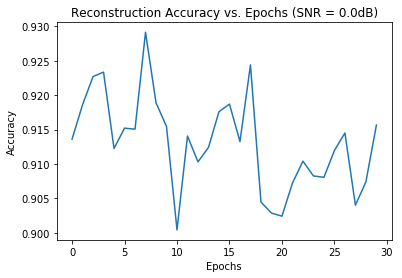

In [101]:
import matplotlib.pyplot as plt

def Plot_Acc(history, i):
  plt.plot(history.history['val_acc'])
  plt.title('Reconstruction Accuracy vs. Epochs (SNR = ' + str(SNR[i]) + 'dB)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

Plot_Acc(history, 0)

Please start here and load already trained models

In [74]:
# import os
# os.chdir('jscc_models_mse')

In [75]:
# # Only use to save models
# for i in range(len(jsccModels)):
#     fName = 'mse_model_' + str(SNR[i]) + '.h5' 
#     jsccModels[i].save_weights(fName)

In [76]:
# Only use to load models
def Load_Model_Weights(testModel, snr):
    fName = 'mse_model_' + str(snr) + '.h5'
    testModel.compile(optimizer='adam',
                    loss='mse',
                    metrics=['categorical_accuracy'])
    testModel.load_weights(fName) # by_name=True

In [8]:
# test = BuildModel(0.61)
# Load_Model_Weights(test, 10.0)
# score = test.evaluate(TestX, Testy, verbose=1)

In [9]:
# score

In [10]:
# jsccModels[0].predict(np.array([[1,0,0,0,0,0,0]]))

Hamming code

In [46]:
# p1, p2, d1, p3, d2, d3, d4
codewords = [[-1,-1,-1,-1,-1,-1],
             [-1,1,-1,1,-1,1],
             [1,-1,-1,1,1,-1],
             [1,1,-1,-1,1,1],
             [1,1,1,-1,-1,-1],
             [1,-1,1,1,-1,1],
             [-1,1,1,1,1,-1],
             [-1,-1,1,-1,1,1]]




In [47]:
def HardDecode(arr):
    narr = []
    for element in arr:
        if element > 0:
            narr.append(1)
        else:
            narr.append(-1)
    return narr

# soft 7,4 hamming code
# vesion can be 1 for 8 bit output or 2 for 7 bit
def Hamming_Soft(inputs, stdev, version=1):
    predicted = []
    for msg in inputs:
        code = codewords[signal.index(msg)]
        encoded = code + stdev * np.random.randn(np.shape(code)[0]) # encoding
        distances = [np.linalg.norm(np.array(encoded)-np.array(cword)) for cword in codewords]
        if version==1:
            predicted.append(target[np.argmin(distances)])
        else:
            predicted.append(signal[np.argmin(distances)])
    return np.array(predicted)

def Hamming_Hard(inputs, stdev, version=1):
    predicted = []
    for msg in inputs:
        code = codewords[signal.index(msg)]
        encoded = code + stdev * np.random.randn(np.shape(code)[0]) # encoding
        encoded = HardDecode(encoded)
        distances = [np.linalg.norm(np.array(encoded)-np.array(cword)) for cword in codewords]
        if version==1:
            predicted.append(target[np.argmin(distances)])
        else:
            predicted.append(signal[np.argmin(distances)])
    return np.array(predicted)

In [48]:
# # Testing!
# Hamming_Soft(signal[0:4], stdRange[2])

**Evaluation Functions**

In [49]:
# hamming distances
hamming_distances = [[0,1,1,1,1,1,1,1],
                     [1,0,2,2,2,2,2,2],
                     [1,2,0,2,2,2,2,2],
                     [1,2,2,0,2,2,2,2],
                     [1,2,2,2,0,2,2,2],
                     [1,2,2,2,2,0,2,2],
                     [1,2,2,2,2,2,0,2],
                     [1,2,2,2,2,2,2,0]]

# bit error rate
def BER(actual, predicted):
    if len(actual) != len(predicted):
        print "BER error: Lengths do not match"
        return
    
    actSignalIndex = [target.index(act) for act in actual]
    predSignalIndex = [[1,2,3,4,5,6,7,0][np.argmax(pred)] for pred in predicted]
    
    return np.mean([hamming_distances[i][j] for i,j in zip(actSignalIndex, predSignalIndex)]) / 7.0
    
    
# block error rate
def BLER(actual, predicted):
    if len(actual) != len(predicted):
        print "BER error: Lengths do not match"
        return
    
    return np.mean([(np.argmax(act) != np.argmax(pred)) for act,pred in zip(actual, predicted)])

def MSE(actual, predicted):
    if len(actual) != len(predicted):
        print "BER error: Lengths do not match"
        return
    
    return np.mean([np.linalg.norm(np.array(act)-np.array(pred)) for act,pred in zip(actual, predicted)])
    

In [50]:
MSE(signal[2:4], signal[0:2])

1.2071067811865475

# DEMO

In [77]:
import os
os.chdir('/home/inimfon/Desktop/jscc_models_mse')

In [78]:
# Test model from -1.0 dB to 10.0 dB

SNR = np.arange(-1.0, 11.0, 0.5)
stdRange = [( 6.0/(14*(10**(snr/10))) )**.5 for snr in SNR] 
# print stdRange

In [79]:
# create channels at each SNR for our jscc model

jsccModels = [BuildModel(std) for std in stdRange]

In [80]:
# Dataset genetation
signal =  [[0,0,0,0,0,0,0],
           [1,0,0,0,0,0,0],
           [0,1,0,0,0,0,0],
           [0,0,1,0,0,0,0],
           [0,0,0,1,0,0,0],
           [0,0,0,0,1,0,0],
           [0,0,0,0,0,1,0],
           [0,0,0,0,0,0,1]]

target =  [[0,0,0,0,0,0,0,1],
           [1,0,0,0,0,0,0,0],
           [0,1,0,0,0,0,0,0],
           [0,0,1,0,0,0,0,0],
           [0,0,0,1,0,0,0,0],
           [0,0,0,0,1,0,0,0],
           [0,0,0,0,0,1,0,0],
           [0,0,0,0,0,0,1,0]]

indexes = np.random.choice(8, 50000)

DemoX = [signal[i] for i in indexes]
Demoy = [target[i] for i in indexes]

In [81]:
# test with jsccc model trained at 2.5 dB

MSE_25 = []

for i in range(len(jsccModels)):
    Load_Model_Weights(jsccModels[i], 2.5)
    DemoPred = jsccModels[i].predict(DemoX)
    MSE_25.append(MSE(DemoX, DemoPred))
    
    print "Simulation on " + str(SNR[i]) + " complete!"

Simulation on -1.0 complete!
Simulation on -0.5 complete!
Simulation on 0.0 complete!
Simulation on 0.5 complete!
Simulation on 1.0 complete!
Simulation on 1.5 complete!
Simulation on 2.0 complete!
Simulation on 2.5 complete!
Simulation on 3.0 complete!
Simulation on 3.5 complete!
Simulation on 4.0 complete!
Simulation on 4.5 complete!
Simulation on 5.0 complete!
Simulation on 5.5 complete!
Simulation on 6.0 complete!
Simulation on 6.5 complete!
Simulation on 7.0 complete!
Simulation on 7.5 complete!
Simulation on 8.0 complete!
Simulation on 8.5 complete!
Simulation on 9.0 complete!
Simulation on 9.5 complete!
Simulation on 10.0 complete!
Simulation on 10.5 complete!


In [82]:
# create channels at each SNR for our jscc model

jsccModels = [BuildModel(std) for std in stdRange]

In [83]:
# test with jsccc model trained at 8.0 dB

MSE_80 = []

for i in range(len(jsccModels)):
    Load_Model_Weights(jsccModels[i], 8.0)
    DemoPred = jsccModels[i].predict(DemoX)
    MSE_80.append(MSE(DemoX, DemoPred))
    
    print "Simulation on " + str(SNR[i]) + " complete!"

Simulation on -1.0 complete!
Simulation on -0.5 complete!
Simulation on 0.0 complete!
Simulation on 0.5 complete!
Simulation on 1.0 complete!
Simulation on 1.5 complete!
Simulation on 2.0 complete!
Simulation on 2.5 complete!
Simulation on 3.0 complete!
Simulation on 3.5 complete!
Simulation on 4.0 complete!
Simulation on 4.5 complete!
Simulation on 5.0 complete!
Simulation on 5.5 complete!
Simulation on 6.0 complete!
Simulation on 6.5 complete!
Simulation on 7.0 complete!
Simulation on 7.5 complete!
Simulation on 8.0 complete!
Simulation on 8.5 complete!
Simulation on 9.0 complete!
Simulation on 9.5 complete!
Simulation on 10.0 complete!
Simulation on 10.5 complete!


In [84]:
# test with Hamming code

MSE_hamming = []

for i in range(len(stdRange)):
    DemoPred = Hamming_Soft(DemoX, stdRange[i], version=2)
    MSE_hamming.append(MSE(DemoX, DemoPred))
    
    print "Simulation on " + str(SNR[i]) + " complete!"

Simulation on -1.0 complete!
Simulation on -0.5 complete!
Simulation on 0.0 complete!
Simulation on 0.5 complete!
Simulation on 1.0 complete!
Simulation on 1.5 complete!
Simulation on 2.0 complete!
Simulation on 2.5 complete!
Simulation on 3.0 complete!
Simulation on 3.5 complete!
Simulation on 4.0 complete!
Simulation on 4.5 complete!
Simulation on 5.0 complete!
Simulation on 5.5 complete!
Simulation on 6.0 complete!
Simulation on 6.5 complete!
Simulation on 7.0 complete!
Simulation on 7.5 complete!
Simulation on 8.0 complete!
Simulation on 8.5 complete!
Simulation on 9.0 complete!
Simulation on 9.5 complete!
Simulation on 10.0 complete!
Simulation on 10.5 complete!


In [85]:
# test with Hamming code (hard decision)

MSE_hamming_hard = []

for i in range(len(stdRange)):
    DemoPred = Hamming_Hard(DemoX, stdRange[i], version=2)
    MSE_hamming_hard.append(MSE(DemoX, DemoPred))
    
    print "Simulation on " + str(SNR[i]) + " complete!"

Simulation on -1.0 complete!
Simulation on -0.5 complete!
Simulation on 0.0 complete!
Simulation on 0.5 complete!
Simulation on 1.0 complete!
Simulation on 1.5 complete!
Simulation on 2.0 complete!
Simulation on 2.5 complete!
Simulation on 3.0 complete!
Simulation on 3.5 complete!
Simulation on 4.0 complete!
Simulation on 4.5 complete!
Simulation on 5.0 complete!
Simulation on 5.5 complete!
Simulation on 6.0 complete!
Simulation on 6.5 complete!
Simulation on 7.0 complete!
Simulation on 7.5 complete!
Simulation on 8.0 complete!
Simulation on 8.5 complete!
Simulation on 9.0 complete!
Simulation on 9.5 complete!
Simulation on 10.0 complete!
Simulation on 10.5 complete!


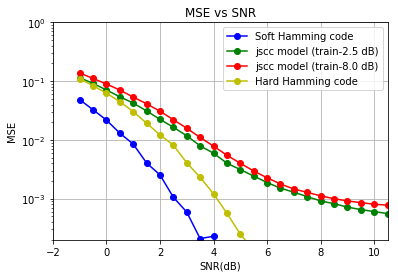

In [88]:
import matplotlib.pyplot as plt
# plot Bit Error results

plt.plot(SNR, MSE_hamming, 'b-o', label='Soft Hamming code')
plt.plot(SNR, MSE_25, 'g-o', label='jscc model (train-2.5 dB)') 
plt.plot(SNR, MSE_80, 'r-o', label='jscc model (train-8.0 dB)')
plt.plot(SNR, MSE_hamming_hard, 'y-o', label='Hard Hamming code')

plt.axis([-2, 10.5, 2e-4, 1])
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('SNR(dB)')
plt.ylabel('MSE')
plt.grid(True)
plt.title('MSE vs SNR')
plt.legend()
plt.show()